## Kaggle

In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wine-quality-dataset/WineQT.csv
/kaggle/input/playground-series-s3e5/sample_submission.csv
/kaggle/input/playground-series-s3e5/train.csv
/kaggle/input/playground-series-s3e5/test.csv


## Bibliotecas

In [3]:
# Bibliotecas para manipulação de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Bibliotecas para warnings e logging
import warnings
import logging
warnings.filterwarnings('ignore')

# Bibliotecas de pré-processamento de dados
from sklearn.preprocessing import StandardScaler, scale, normalize

# Bibliotecas de modelos de machine learning
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Bibliotecas para Balanceamento
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Bibliotecas para validação e otimização de modelos
from sklearn.model_selection import cross_val_score, GridSearchCV
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

# Bibliotecas de avaliação de modelos
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_absolute_error, ConfusionMatrixDisplay

## Estilos

<Figure size 640x480 with 0 Axes>

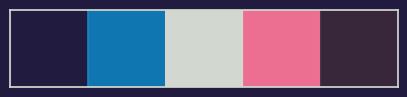

In [4]:
palette = ['#211B3F', '#0F76B1', '#D2D7D0', '#EC6F92', '#38273A']

rc = {
    "axes.facecolor": palette[0],
    "figure.facecolor": palette[0],
    "axes.edgecolor": palette[2],
    "grid.color": palette[2],
    "font.family": "serif",
    "axes.labelcolor": palette[2], 
    "xtick.color": palette[2],
    "ytick.color": palette[2],
    "legend.labelcolor": palette[2],
    "legend.edgecolor": palette[0],
    "legend.facecolor": palette[0],
    "grid.alpha": 0.1
}

sns.set(rc=rc)

sns.despine()

sns.palplot(palette)

#plt.show()

## Dados

In [5]:
dados_train = pd.read_csv("../input/playground-series-s3e5/train.csv")
dados_test = pd.read_csv("../input/playground-series-s3e5/test.csv")
dados_exemplo = pd.read_csv("../input/playground-series-s3e5/sample_submission.csv")

original = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv',index_col='Id')

print("feito")

dados_train = pd.concat([dados_train,original]).drop_duplicates()

feito


## Submeter?

In [ ]:
submeter = True

## Análise de Dados 1

In [7]:
print(dados_test.shape)
print(dados_train.shape)

(1372, 12)
(3074, 13)


In [80]:
print(dados_test.shape)
print(dados_train.shape)

(1372, 12)
(2056, 13)


In [81]:
#train.isnull().sum()
dados_test.isnull().sum()

Id                      0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

<Axes: xlabel='quality', ylabel='count'>

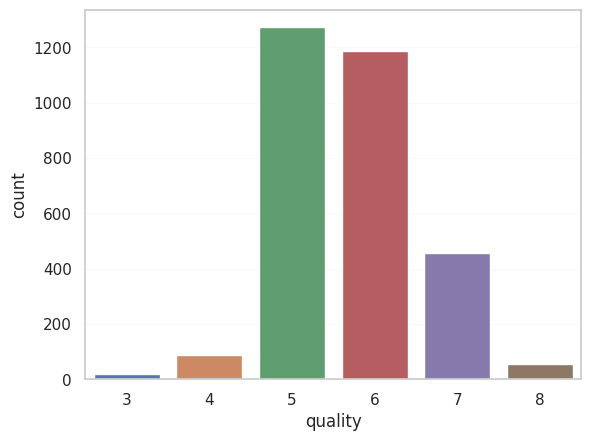

In [130]:
sns.set_style('whitegrid')
sns.countplot(x='quality',data=dados_train)

## Tratamento de Dados

In [7]:
train = dados_train.copy()
test = dados_test.copy()

train['quality'] = train['quality']-3
train = train.drop(columns=['Id'])
#test = test.drop(columns=['Id'])

def add_features(df):
    # referred to
    # https://www.kaggle.com/competitions/playground-series-s3e5/discussion/382891
    df['mso2'] = df['free sulfur dioxide']/(1+ 10**(df['pH'] -1.81))
    # referred to 
    # https://www.kaggle.com/competitions/playground-series-s3e5/discussion/382698
    df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
    df['mean_acid'] = df[['fixed acidity','volatile acidity','citric acid']].mean(axis=1)
    df['std_acid'] =  df[['fixed acidity','volatile acidity','citric acid']].std(axis=1)
    df['acid/density'] = df['total_acid'] / df['density']
    df['alcohol_density'] = df['alcohol'] * df['density']
    df['sulphate/density'] = df['sulphates'] / df['density']
    df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
    df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
    df['sulphates*alcohol'] = df['sulphates'] / df['alcohol']
    
    df.drop(["fixed acidity", "volatile acidity", "citric acid", "total_acid", "density","sulphates","chlorides","alcohol"], axis = 1, inplace = True)
    #df.drop(["fixed acidity", "volatile acidity", "citric acid", "total_acid", "density","sulphates","chlorides","alcohol","fixed acidity","volatile acidity","volatile acidity"], axis = 1, inplace = True)

    return df

train = add_features(train)
test = add_features(test)
print("feito")

feito


### Remover Outliers

In [96]:
# Fazer isso diminuiu o resultado no teste
remover = False
if remover == True:
    # Defina as colunas nas quais você deseja remover os outliers
    #colunas_para_limpar = ['coluna1', 'coluna2']  # Substitua pelos nomes das colunas desejadas
    colunas_para_limpar = train.select_dtypes(include=['float64', 'int64']).columns
    colunas_para_limpar = train.columns.drop('quality')

    # Filtre apenas as linhas onde `quality` é igual a 2 ou 3
    train_filtrado = train[train['quality'].isin([2, 3])]

    # Para cada coluna nas colunas selecionadas
    for coluna in colunas_para_limpar:
        # Calcule o primeiro e o terceiro quartis (Q1 e Q3)
        Q1 = train_filtrado[coluna].quantile(0.25)
        Q3 = train_filtrado[coluna].quantile(0.75)
        IQR = Q3 - Q1  # Intervalo interquartil

        # Defina os limites para identificar outliers
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Remova as linhas que estão fora dos limites apenas nas linhas filtradas
        train = train[~((train['quality'].isin([2, 3])) & ((train[coluna] < limite_inferior) | (train[coluna] > limite_superior)))]

In [99]:
train.shape
#colunas_para_limpar

(3074, 14)

## Análise de Dados 2

<Axes: xlabel='quality', ylabel='count'>

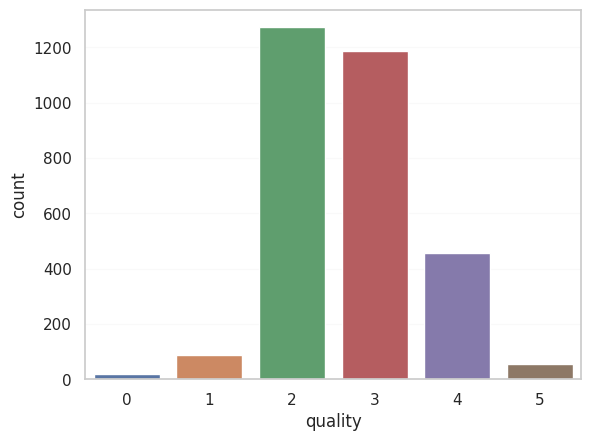

In [139]:
sns.set_style('whitegrid')
sns.countplot(x='quality',data=train)

In [18]:
train.describe()

,residual sugar,free sulfur dioxide,total sulfur dioxide,pH,quality,mso2,acid/density,alcohol_density,sulphate/density,sulphates/acid,sulphates/chlorides,sulphates*alcohol
count,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000,3074.000000
mean,2.440452,16.523097,48.272772,3.310878,2.694535,0.520052,9.163469,10.392508,0.648552,1.408124,8.332621,0.062334
std,1.033867,10.082395,33.038049,0.147593,0.840360,0.361461,1.796566,1.039305,0.148958,0.717810,3.025452,0.014820
min,0.900000,1.000000,6.000000,2.740000,0.000000,0.024503,5.305013,8.394960,0.330927,0.253165,1.368715,0.031250
25%,1.900000,7.000000,22.000000,3.210000,2.000000,0.246701,7.910341,9.482900,0.551323,0.898551,6.486486,0.053465
50%,2.200000,15.000000,42.000000,3.310000,3.000000,0.435669,8.785494,10.074750,0.619752,1.222222,7.752809,0.059804
75%,2.600000,23.000000,65.000000,3.390000,3.000000,0.703746,10.000752,11.051326,0.721428,1.714286,9.577465,0.067708
max,15.500000,68.000000,289.000000,4.010000,5.000000,3.364391,16.990630,14.864240,2.000800,6.964286,60.833333,0.212766


In [10]:
def data_info(df):
    matrix = pd.DataFrame(data=df.dtypes, columns=['Dtypes'], index=df.columns)
    matrix['SingleData'] = df.nunique().values == 1
    matrix['Bool'] = df.nunique().values == 2
    matrix['#Null'] = df.isnull().sum().values
    matrix['%Null'] = np.round(df.isnull().sum().values / len(df), 3)
    matrix['Unique'] = df.nunique().values
    
    for col in df.select_dtypes(include=[np.number]).columns:
        matrix.loc[col, 'Min'] = df[col].min()
        matrix.loc[col, 'Max'] = df[col].max()
        matrix.loc[col, 'Mean'] = df[col].mean()
        matrix.loc[col, 'Std'] = df[col].std()
        matrix.loc[col, '0.25'] = df[col].quantile(0.25)
        matrix.loc[col, '0.5'] = df[col].median()
        matrix.loc[col, '0.75'] = df[col].quantile(0.75)
    
    print(f'Number of entries: {df.shape[0]}\nNumber of features: {df.shape[1]}')

    return matrix.sort_values(['Dtypes', 'Mean']).style.background_gradient(subset=['Mean', 'Std'], cmap='RdPu').background_gradient(subset=['Unique'], cmap='Blues')

def render_confusion_matrix(y_true, y_pred, figsize=(13,8)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')

data_info(train)

Number of entries: 3074
Number of features: 14


,Dtypes,SingleData,Bool,#Null,%Null,Unique,Min,Max,Mean,Std,0.25,0.5,0.75
quality,int64,False,False,0,0.000000,6,0.000000,5.000000,2.694535,0.840360,2.000000,3.000000,3.000000
sulphates*alcohol,float64,False,False,0,0.000000,1249,0.031250,0.212766,0.062334,0.014820,0.053465,0.059804,0.067708
mso2,float64,False,False,0,0.000000,1435,0.024503,3.364391,0.520052,0.361461,0.246701,0.435669,0.703746
sulphate/density,float64,False,False,0,0.000000,2293,0.330927,2.000800,0.648552,0.148958,0.551323,0.619752,0.721428
sulphates/acid,float64,False,False,0,0.000000,1571,0.253165,6.964286,1.408124,0.717810,0.898551,1.222222,1.714286
residual sugar,float64,False,False,0,0.000000,84,0.900000,15.500000,2.440452,1.033867,1.900000,2.200000,2.600000
mean_acid,float64,False,False,0,0.000000,1301,1.756667,5.681667,3.045217,0.601178,2.626667,2.916667,3.326667
pH,float64,False,False,0,0.000000,88,2.740000,4.010000,3.310878,0.147593,3.210000,3.310000,3.390000
std_acid,float64,False,False,0,0.000000,2834,2.469339,8.947914,4.590674,0.966387,3.917866,4.358692,5.051369
sulphates/chlorides,float64,False,False,0,0.000000,1589,1.368715,60.833333,8.332621,3.025452,6.486486,7.752809,9.577465


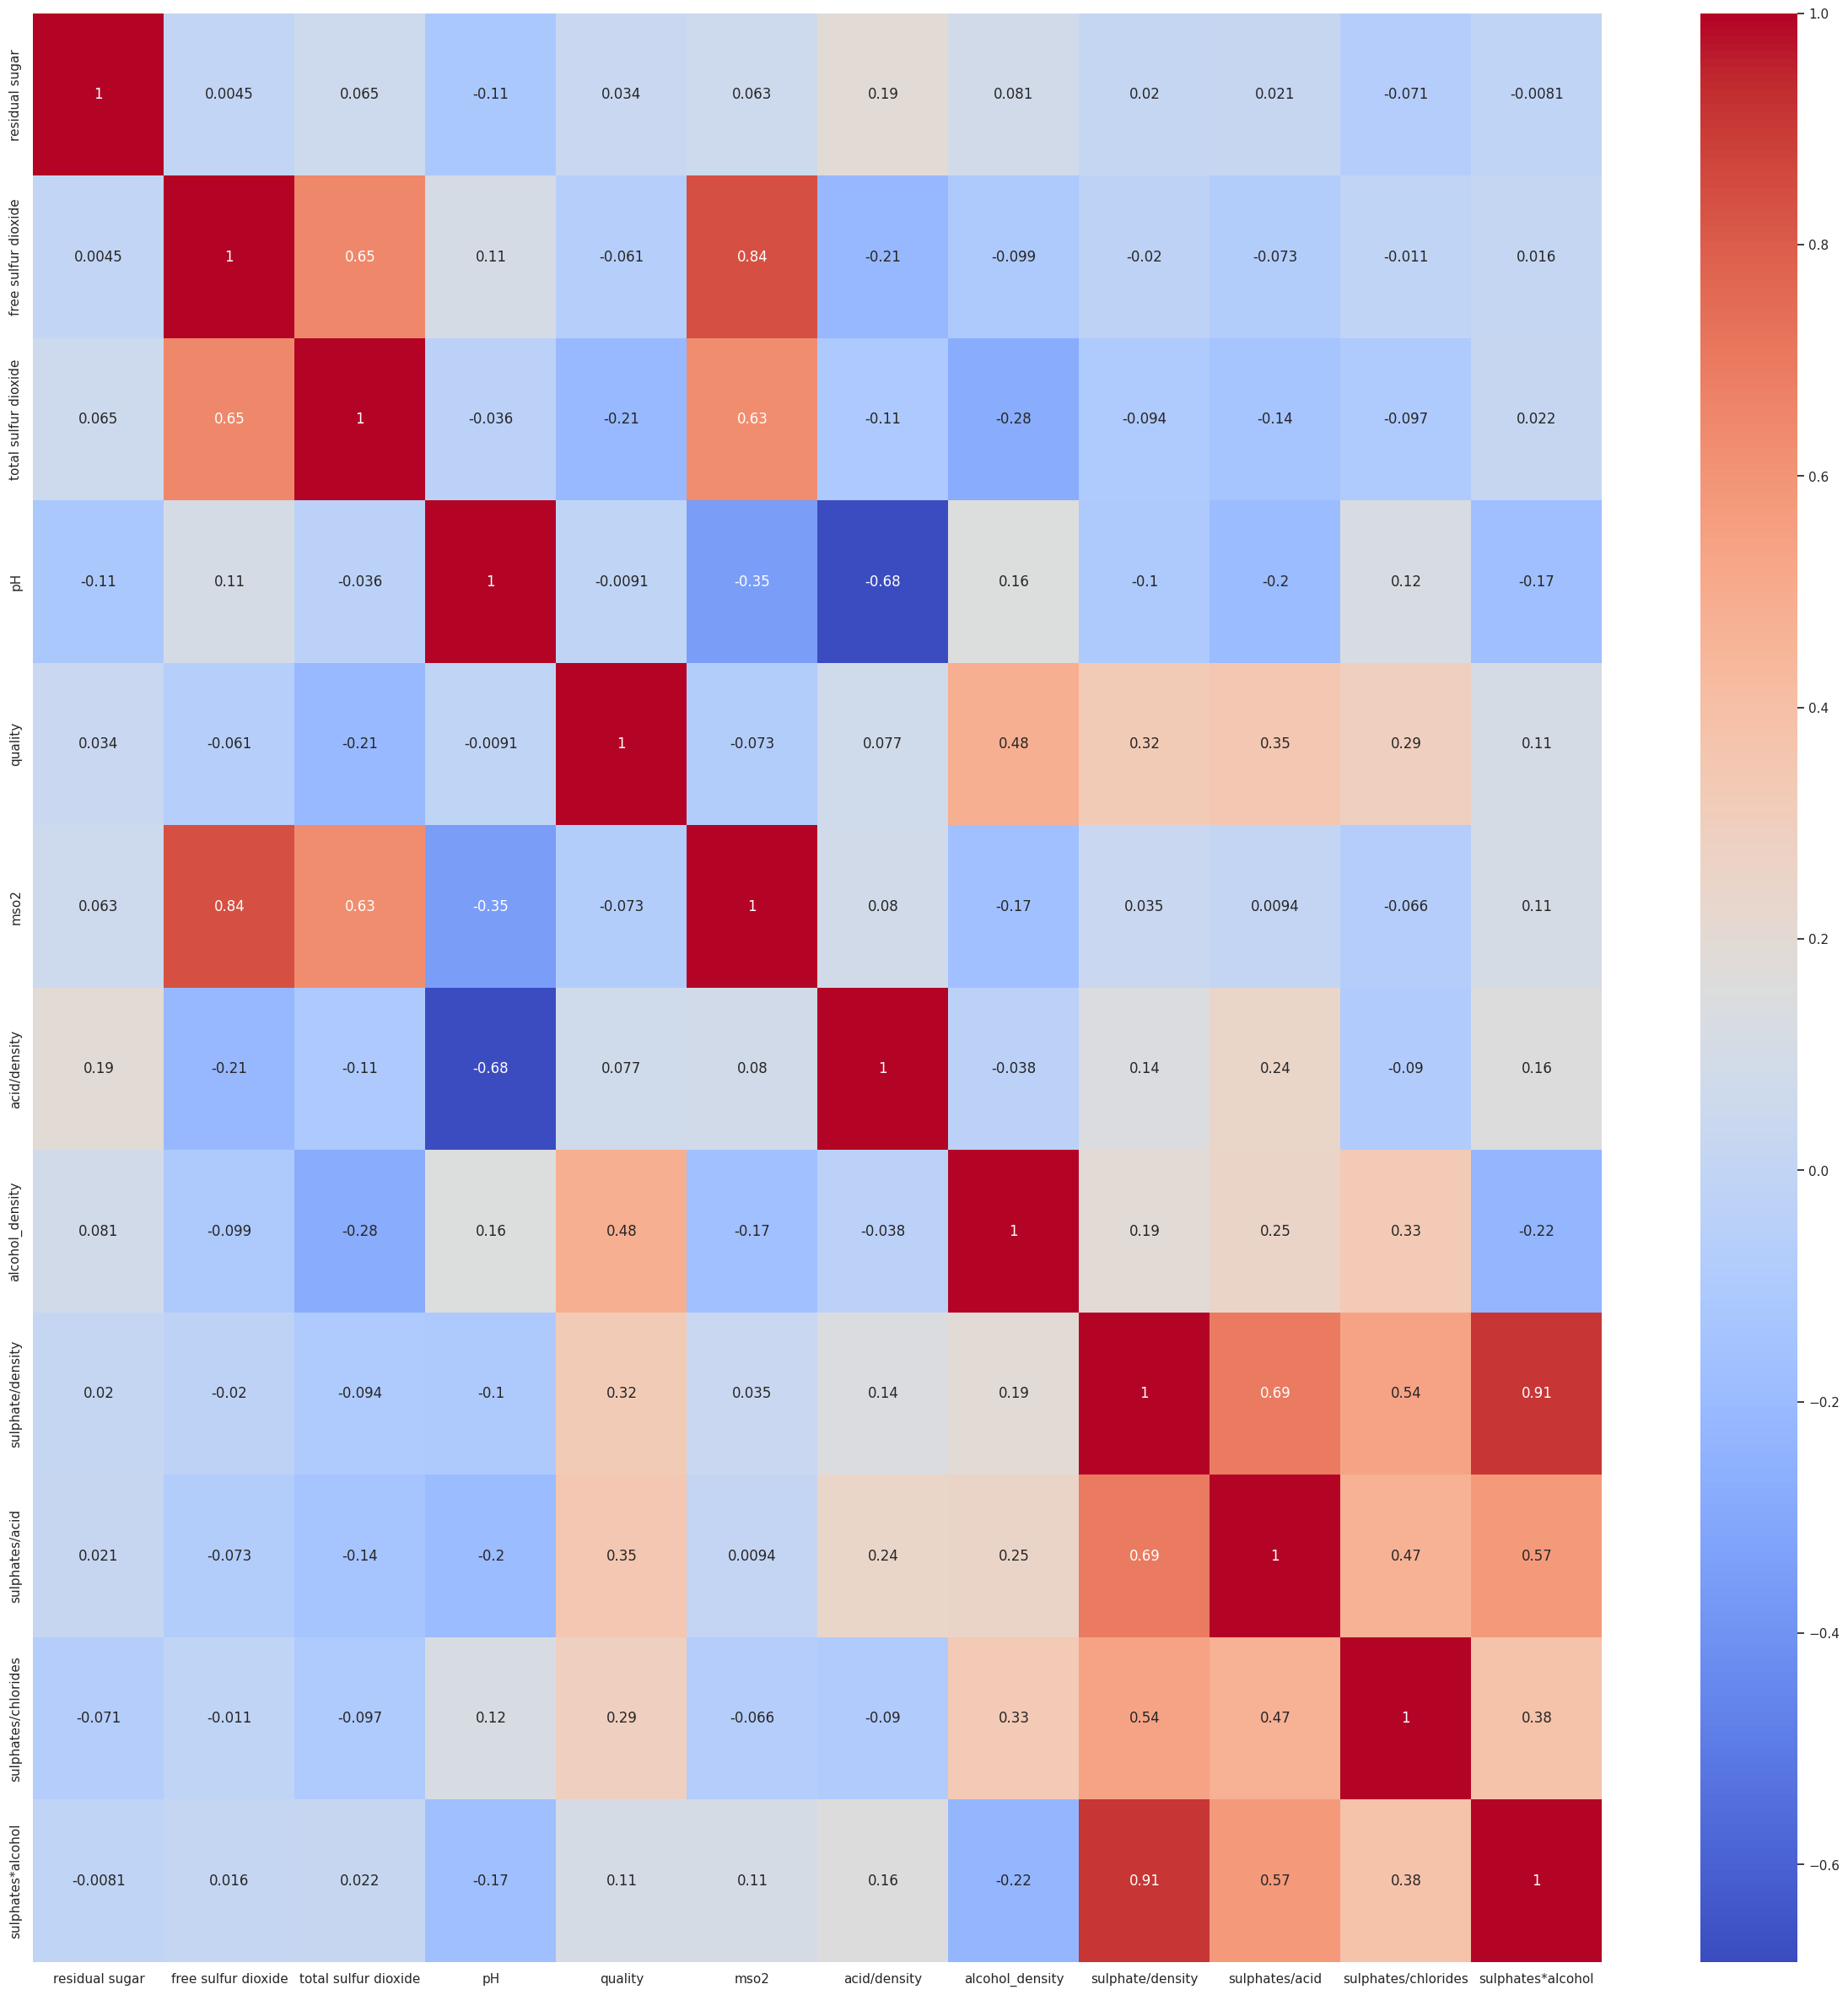

In [17]:
plt.figure(figsize=(30, 30))
corr_matrix = train.corr()
#sns.heatmap(corr_matrix.iloc[0:1], annot=True, cmap="coolwarm")
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()
#corr_matrix

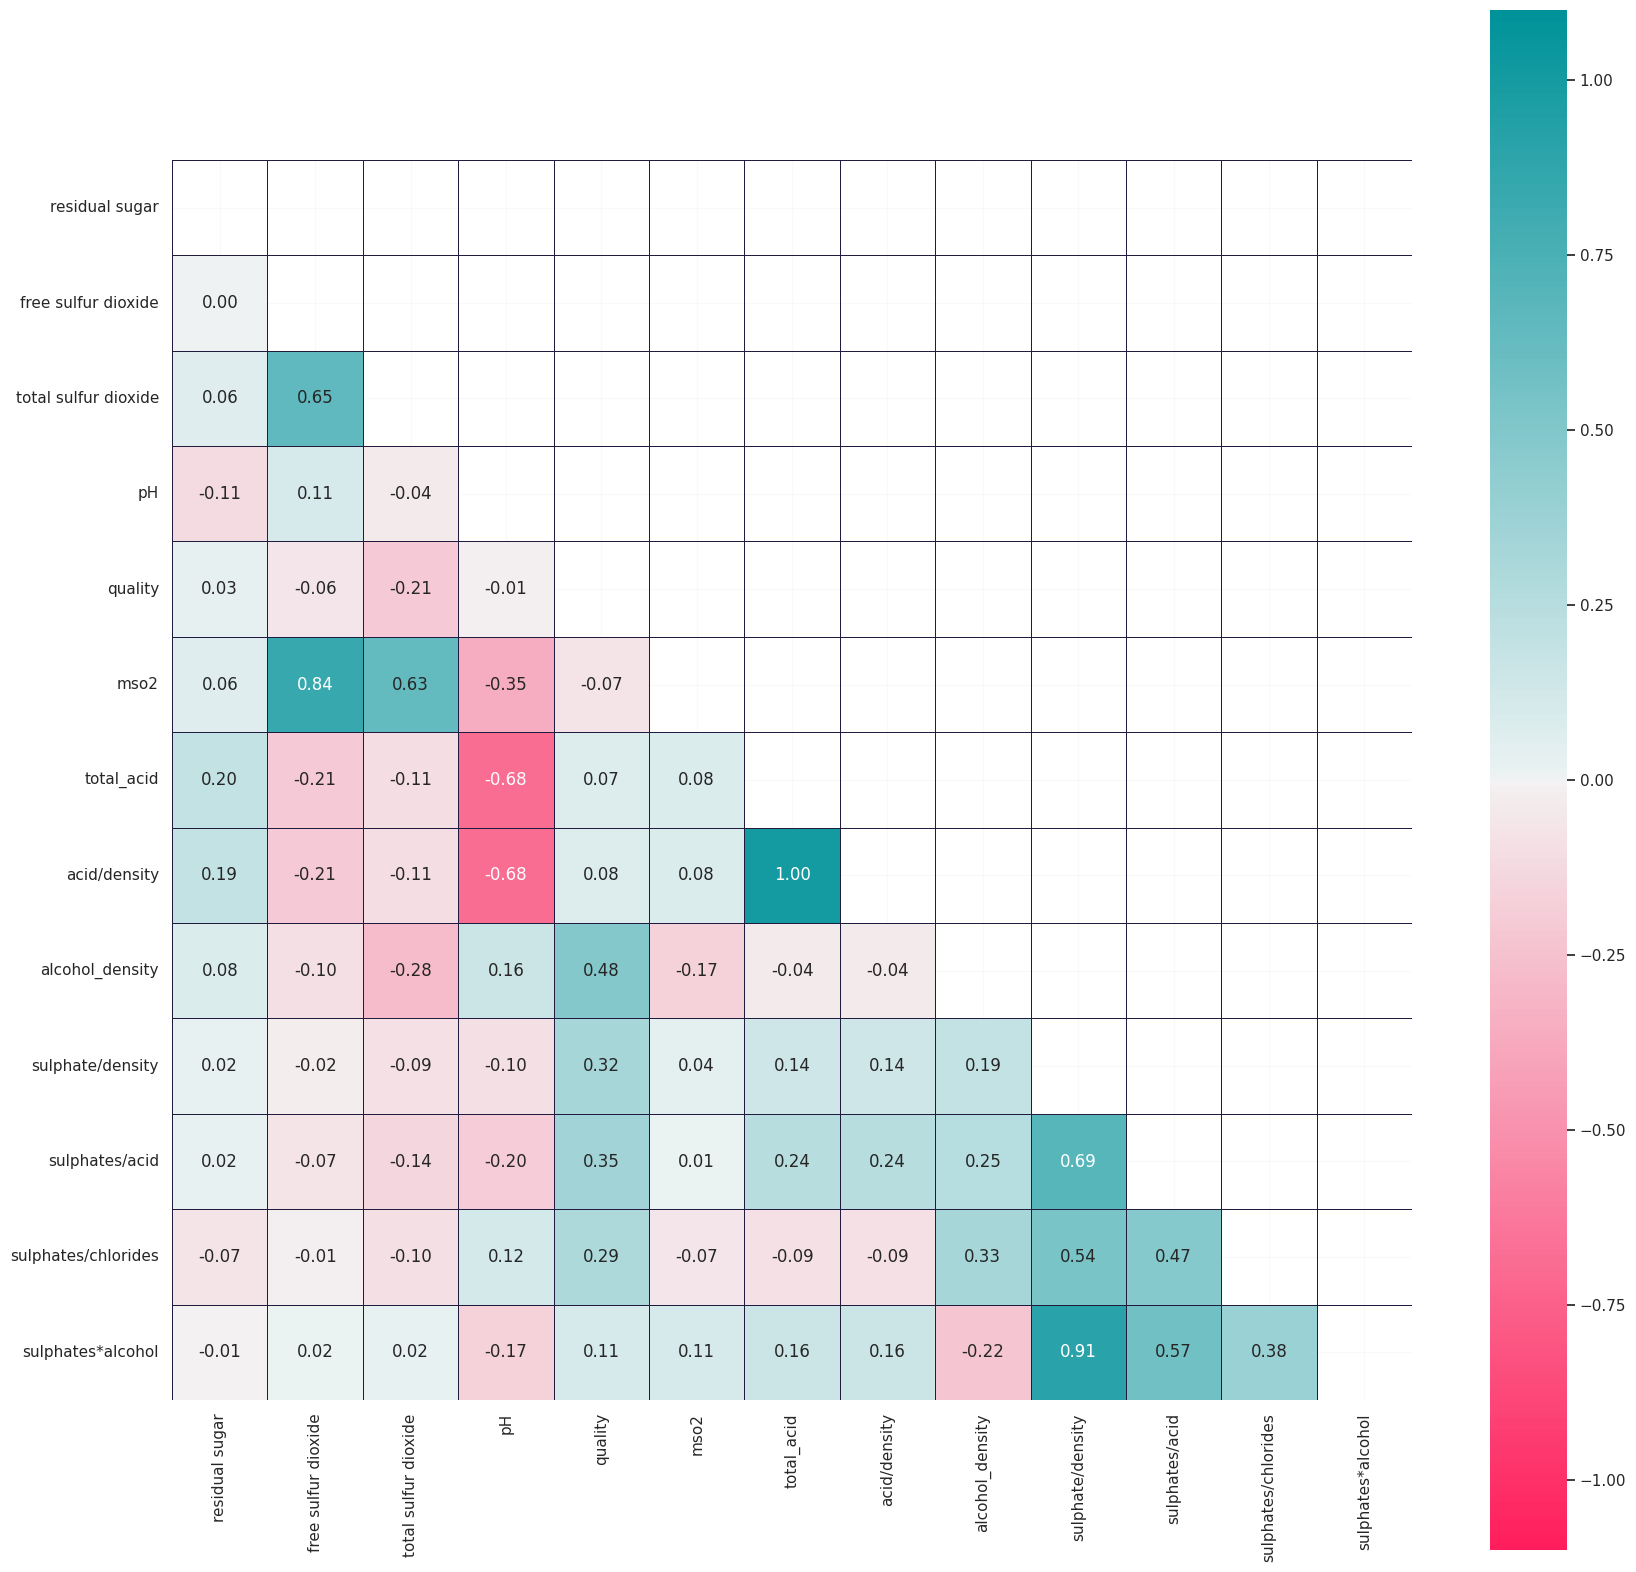

In [21]:
def corr_matrix(matrix, figsize=(15,15), cmap=sns.diverging_palette(5, 200, sep=1, s=100, l=55, as_cmap=True), title='Correlation Matrix'):
    mask = np.triu(np.ones_like(
                   matrix.corr(), 
                   dtype=bool))
    
    fig = plt.figure(figsize=figsize)
    sns.heatmap(matrix,
                annot=True,
                cmap=cmap,
                fmt='.2f',
                square=True,
                mask=mask,
                linewidths=0.7,
                linecolor='#211B3F',
                vmin=-1.1,
                vmax=1.1)
    
    
    #plt.title(title)
    #plt.show()
        
matrix = train.corr()
corr_matrix(matrix, figsize=(20, 20))

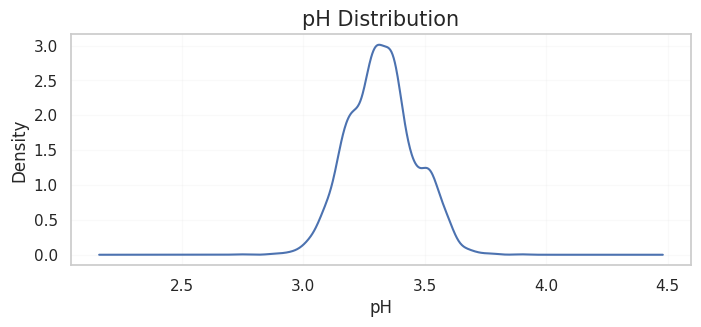

In [57]:
plt.figure(figsize=(8, 3))
train['pH'].plot(
    kind='kde'
)
plt.title('pH Distribution', fontsize=15)
plt.xlabel('pH')
plt.show()

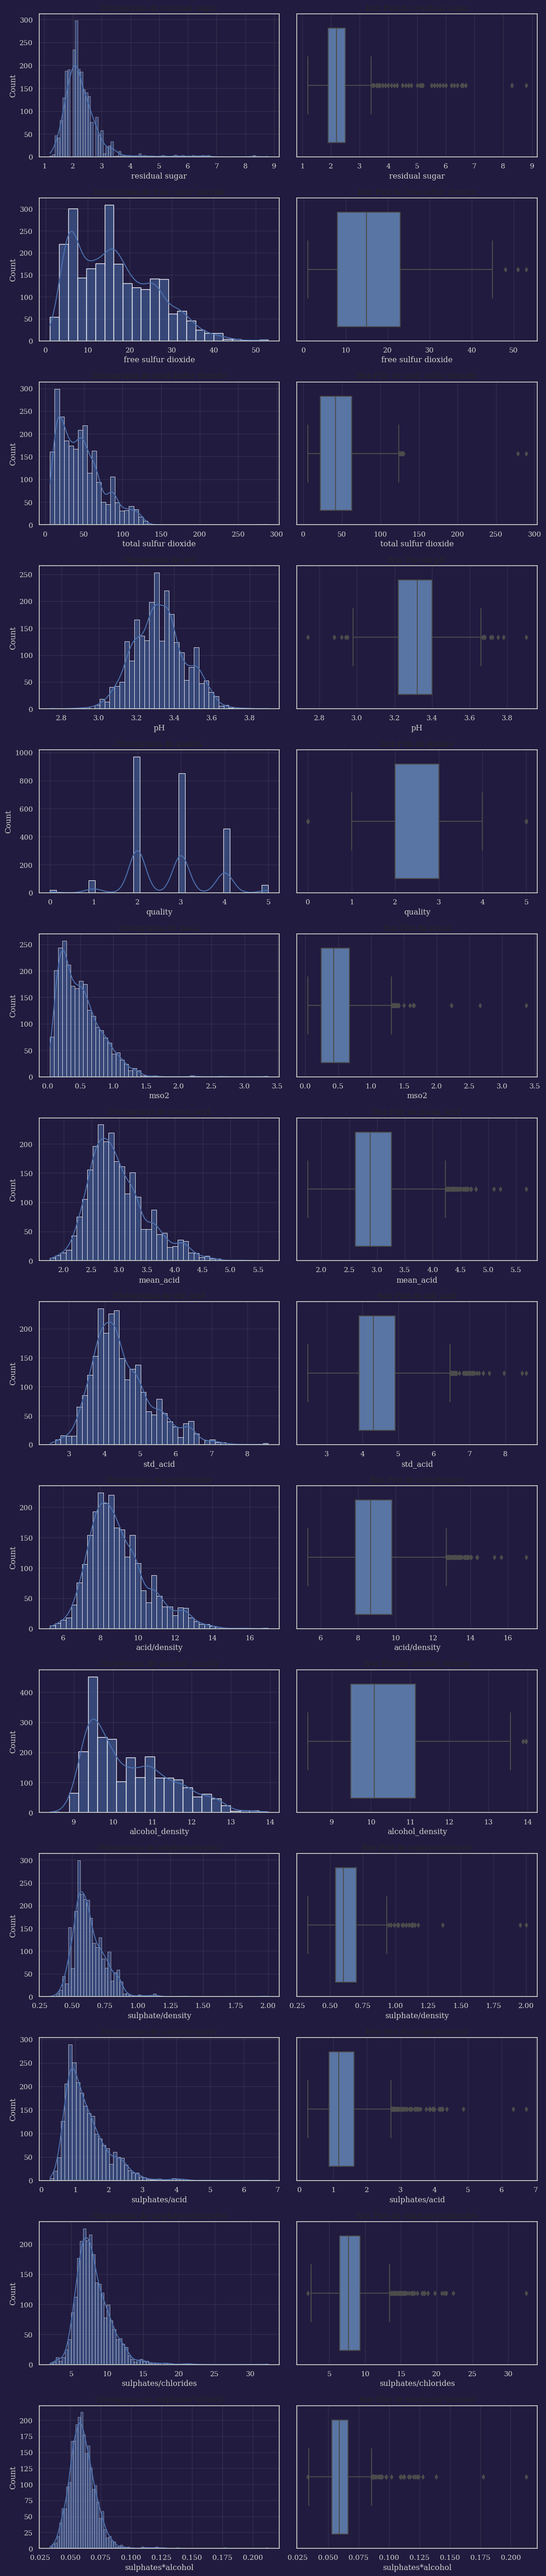

In [85]:
if submeter == False:
    # Número de colunas no dataframe
    num_columns = train.shape[1]

    # Tamanho da figura: ajustado para uma linha de histogramas e box plots por coluna do dataframe
    fig, axes = plt.subplots(num_columns, 2, figsize=(12, 4 * num_columns))

    # Loop para cada coluna
    for i, column in enumerate(train.columns):
        # Histograma
        sns.histplot(train[column], ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'Histograma de {column}')

        # Box plot
        sns.boxplot(x=train[column], ax=axes[i, 1])
        axes[i, 1].set_title(f'Box Plot de {column}')

    # Ajuste de layout para evitar sobreposição de textos
    plt.tight_layout()
    plt.show()


## Pre-processamento dos Dados

In [8]:
# Separa a coluna alvo 'Survived' em y
y = train['quality']

# Separa outras colunas em X
X = train.drop(columns=['quality'])

# Dividir dataset em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

### Normalização

In [ ]:
# Fazer Normalização - Não tive bons resultados
normalizar = False
if normalizar == True:
    scaler = StandardScaler()
    numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
    X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])

### Balanceamento

In [11]:
taxa = 0.35
#melhor = 0.3 - rf

undersampling = True
oversampling = True

if undersampling == True:
    if submeter == False:
        # Calcule o número de amostras nas classes
        class_counts = y_train.value_counts()

        # Identifique as 3 classes majoritárias (com o maior número de amostras)
        top_3_majority_classes = class_counts.nlargest(3).index

        # Calcule o número de amostras desejadas para as classes majoritárias (reduzir em 10%)
        sampling_strategy = {}

        # Aplique undersampling nas 3 classes majoritárias (reduzir 10%)
        for class_label, count in class_counts.items():
            if class_label in top_3_majority_classes:  # Aplique apenas nas 3 classes majoritárias
                target_count = int(count * (1-taxa))  # Reduza 10% da quantidade atual
                sampling_strategy[class_label] = target_count
            else:
                # Deixe as outras classes com seu valor original
                sampling_strategy[class_label] = count

        # Aplique o RandomUnderSampler com a estratégia calculada
        under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
        X_res, y_res = under_sampler.fit_resample(X_train, y_train)

        # Verifique o balanceamento das classes após o Undersampling
        print("Distribuição das classes antes do Undersampling:", y_train.value_counts())
        print("Distribuição das classes após o Undersampling:", y_res.value_counts())
        X_train = X_res
        y_train = y_res
    else:
        # Calcule o número de amostras nas classes
        class_counts = y.value_counts()

        # Identifique as 3 classes majoritárias (com o maior número de amostras)
        top_3_majority_classes = class_counts.nlargest(3).index

        # Calcule o número de amostras desejadas para as classes majoritárias (reduzir em 10%)
        sampling_strategy = {}

        # Aplique undersampling nas 3 classes majoritárias (reduzir 10%)
        for class_label, count in class_counts.items():
            if class_label in top_3_majority_classes:  # Aplique apenas nas 3 classes majoritárias
                target_count = int(count * (1-taxa))  # Reduza 10% da quantidade atual
                sampling_strategy[class_label] = target_count
            else:
                # Deixe as outras classes com seu valor original
                sampling_strategy[class_label] = count

        # Aplique o RandomUnderSampler com a estratégia calculada
        under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
        X_res, y_res = under_sampler.fit_resample(X, y)

        # Verifique o balanceamento das classes após o Undersampling
        print("Para submeter")
        print("Distribuição das classes antes do Undersampling:", y.value_counts())
        print("Distribuição das classes após o Undersampling:", y_res.value_counts())
        X_train = X_res
        y_train = y_res
    
# Fazer OverSampling
if oversampling == True:
    if submeter == False:
        # Calcule o número de amostras nas classes
        class_counts = y_train.value_counts()

        # Identifique a classe majoritária
        majority_class_count = class_counts.max()

        # Calcule o número de amostras desejadas para cada classe minoritária
        sampling_strategy = {}

        # Aumente cada classe minoritária em 10% do seu número atual de amostras
        for class_label, count in class_counts.items():
            if count < majority_class_count:  # Aplique SMOTE apenas para as classes minoritárias
                target_count = int(count * (1+taxa))  # Aumente 10% da quantidade atual
                # Verifique se o aumento ultrapassa o número de amostras da classe majoritária
                if target_count > majority_class_count:
                    target_count = majority_class_count  # Não ultrapasse a classe majoritária
                sampling_strategy[class_label] = target_count

        # Aplique o SMOTE com a estratégia calculada
        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        # Verifique o balanceamento das classes após o SMOTE
        print("Distribuição das classes antes do SMOTE:", y_train.value_counts())
        print("Distribuição das classes após o SMOTE:", y_res.value_counts())

        X_train = X_res
        y_train = y_res
    else:
        # Calcule o número de amostras nas classes
        class_counts = y.value_counts()

        # Identifique a classe majoritária
        majority_class_count = class_counts.max()

        # Calcule o número de amostras desejadas para cada classe minoritária
        sampling_strategy = {}

        # Aumente cada classe minoritária em 10% do seu número atual de amostras
        for class_label, count in class_counts.items():
            if count < majority_class_count:  # Aplique SMOTE apenas para as classes minoritárias
                target_count = int(count * (1+taxa))  # Aumente 10% da quantidade atual
                # Verifique se o aumento ultrapassa o número de amostras da classe majoritária
                if target_count > majority_class_count:
                    target_count = majority_class_count  # Não ultrapasse a classe majoritária
                sampling_strategy[class_label] = target_count

        # Aplique o SMOTE com a estratégia calculada
        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
        X_res, y_res = smote.fit_resample(X, y)

        # Verifique o balanceamento das classes após o SMOTE
        print("Para submeter")
        print("Distribuição das classes antes do SMOTE:", y.value_counts())
        print("Distribuição das classes após o SMOTE:", y_res.value_counts())

        X = X_res
        y = y_res

Distribuição das classes antes do Undersampling: quality
2    814
3    814
4    349
1     84
5     51
0     16
Name: count, dtype: int64
Distribuição das classes após o Undersampling: quality
2    569
3    569
4    244
1     84
5     51
0     16
Name: count, dtype: int64
Distribuição das classes antes do SMOTE: quality
2    569
3    569
4    244
1     84
5     51
0     16
Name: count, dtype: int64
Distribuição das classes após o SMOTE: quality
2    569
3    569
4    317
1    109
5     66
0     20
Name: count, dtype: int64


## Busca por Hiper Parâmetros

### Busca Bayesiana

In [108]:
# HyperOpt - Busca Bayesiana

if submeter == False:

    #!pip install hyperopt

    # Modelos - aqui são as classes, não as instâncias já criadas
    models = {
        'logistic_regression': LogisticRegression,
        'rf': RandomForestClassifier,
        'knn': KNeighborsClassifier,
        'svc': SVC,
        'decision_tree': DecisionTreeClassifier,
        'xgboost': XGBClassifier,
        'catboost': CatBoostClassifier,
        'lgbm': LGBMClassifier,
        'bagging': BaggingClassifier
    }

    base_X_train = X_train.copy()
    base_y_train = y_train.copy()

    def search_space(model):
        model = model.lower()
        space = {}
        if model == 'bagging':
            space = {
                #'n_estimators': hp.choice('n_estimators', range(10, 200)),  # Número de estimadores
                'max_samples': hp.uniform('max_samples', 0.1, 1.0),  # Proporção do conjunto de dados
                'max_features': hp.uniform('max_features', 0.1, 1.0),  # Proporção de características
                'bootstrap': hp.choice('bootstrap', [True, False]),  # Amostragem com reposição
                'base_estimator': hp.choice('base_estimator', [
                    LogisticRegression(),  # Corrigido: agora passando a instância
                    #RandomForestClassifier(),
                    DecisionTreeClassifier()
                ])  # Instâncias de modelos de base para o Bagging
            }
        elif model == 'catboost':
            space = {
                'iterations': hp.choice('iterations', range(100,102)),
                'depth': hp.choice('depth', range(3, 10)),
                'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
                'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
                'border_count': hp.choice('border_count', range(32, 255))
            }
        elif model == 'lgbm':
            space = {
                'n_estimators': hp.choice('n_estimators', range(100, 1000)),
                'max_depth': hp.choice('max_depth', range(3, 15)),
                'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
                'num_leaves': hp.choice('num_leaves', range(20, 150)),
                'feature_fraction': hp.uniform('feature_fraction', 0.5, 1.0)
            }
        elif model == 'knn':
            space = {
                'n_neighbors': hp.choice('n_neighbors', range(3, 100)),
                'p': hp.choice('p', range(1, 20))
                #'scale': hp.choice('scale', [0, 1]),
                #'normalize': hp.choice('normalize', [0, 1]),
            }
        elif model == 'svc':
          space = {
              'C': hp.uniform('C', 0, 1000),
              #'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
              'gamma': hp.choice('gamma', ['auto', 'scale']),  # Substitua 'RS*' por 'scale'
              'class_weight': hp.choice('class_weight', ['balanced', None])  # Corrigido de 'kernel' para 'class_weight'
          }

        elif model == 'logistic_regression':
            space = {
                #'fit_intercept': hp.choice('fit_intercept', [True, False]),
                #'C': hp.uniform('C', 0.05, 3),
                'C': hp.uniform('C', 0.05, 100),
                'solver': hp.choice('solver', ['liblinear']),
                #'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear']),
                #'max_iter': hp.choice('max_iter', range(2, 1000)),
                #'multi_class': 'auto',
                #'class_weight': 'balanced'
                'penalty': hp.choice('penalty',['l1','l2'])
            }

        elif model == 'rf':
            space = {
                'max_depth': hp.choice('max_depth', range(1, 200)),
                'min_samples_split': hp.choice('min_samples_split', range(2, 40)),
                'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 20)),
                'max_features': hp.choice('max_features', range(1, 3)),
                'n_estimators': hp.choice('n_estimators', range(50, 1200))
            }

        elif model == 'decision_tree':  # Adicionando Decision Tree
            space = {
                'criterion': hp.choice('criterion', ['gini', 'entropy']),
                'max_depth': hp.choice('max_depth', range(1, 100)),
                'min_samples_split': hp.choice('min_samples_split', range(2, 100)),
                'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 20)),
                'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
            }

        elif model == 'xgboost':  # Adicionando espaço de busca para o XGBoost
            space = {
                'eta': hp.choice('eta', [0.01, 0.015, 0.025, 0.05, 0.1]),
                'gamma': hp.choice('gamma', [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]),
                'max_depth': hp.choice('max_depth', [3, 5, 7, 9, 12, 15, 17, 25]),
                'min_child_weight': hp.choice('min_child_weight', [1, 3, 5, 7]),
                'subsample': hp.choice('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
                'colsample_bytree': hp.choice('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0]),
                'lambda': hp.choice('lambda', [0.01, 0.1, 1.0]),  # RS* não é suportado diretamente
                'alpha': hp.choice('alpha', [0, 0.1, 0.5, 1.0])   # RS* removido para evitar erro
             }

        space['model'] = model
        return space

    def get_acc_status(clf, X_, y):
        acc = cross_val_score(clf, X_, y, cv=5).mean()
        return {'loss': -acc, 'status': STATUS_OK}

    def scale_normalize(params, X_):
        if params.get('scale', 0):
            X_ = scale(X_)
        if params.get('normalize', 0):
            X_ = normalize(X_)
        return X_

    def obj_fnc(params):
        model_name = params.get('model').lower()
        X_ = scale_normalize(params, base_X_train[:])  # Agora usando X_train
        del params['model']

        # Instanciar o modelo com os parâmetros ajustados
        clf = models[model_name](**params)

        return get_acc_status(clf, X_, base_y_train)  # Agora usando y_train

    hypopt_trials = Trials()

    # Executando a busca bayesiana
    best_params = fmin(
        fn=obj_fnc,
        space=search_space('decision_tree'),  # Ajuste aqui o modelo desejado ('knn', 'svc', etc.)
        algo=tpe.suggest,
        max_evals=110,
        trials=hypopt_trials
    )

    print(best_params)
    print(hypopt_trials.best_trial['result']['loss'])

### Grid Search

#### Random Forest

In [109]:
# Random Forest

if submeter == False:
    
    # Supondo que base_X_train e base_y_train sejam os seus dados de treinamento
    base_X_train = X_train.copy()
    base_y_train = y_train.copy()

    # Inicializando o modelo
    rf = RandomForestClassifier()

    # Definir o grid de hiperparâmetros a serem testados
    param_grid = {
        'n_estimators': [350],        # Número de árvores na floresta
        'max_depth': [95],             # Profundidade máxima de cada árvore
        'max_features': ['log2'],         # Número máximo de características para dividir
        'min_samples_split': [9],             # Número mínimo de amostras para dividir um nó
        'min_samples_leaf': [5,6,7,8]           # Número mínimo de amostras em uma folha
    }

    #{'max_depth': 122, 'max_features': 1, 'min_samples_leaf': 18, 'min_samples_split': 5, 'n_estimators': 858}


    # Calcular o número de combinações de hiperparâmetros
    n_combinations = np.prod([len(v) for v in param_grid.values()])

    # Inicializar a barra de progresso
    with tqdm(total=n_combinations) as pbar:
        # Função para atualizar a barra de progresso
        def progress_callback(*args, **kwargs):
            pbar.update(1)

        # Configurar o GridSearchCV com verbose e a barra de progresso
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=3  # Aumente o verbose para exibir mais detalhes durante o processo
        )

        # Realizar o GridSearch sem passar o callback diretamente
        grid_search.fit(base_X_train, base_y_train)

    # Exibir os melhores parâmetros e o melhor score
    print("Melhores parâmetros encontrados:", grid_search.best_params_)
    print("Melhor score de acurácia:", grid_search.best_score_)

#### KNN

In [110]:
# KNN
if submeter == False:

    # Supondo que base_X_train e base_y_train sejam os seus dados de treinamento
    base_X_train = X_train.copy()
    base_y_train = y_train.copy()

    # Inicializando o modelo KNN
    knn = KNeighborsClassifier()

    # Grade de parâmetros para otimização
    param_grid = {
        'n_neighbors': list(range(1, 100, 5)),        # Número de vizinhos (de 1 a 50 com passo de 5)
        'weights': ['uniform', 'distance'],          # Peso uniforme ou por distância
        'metric': ['euclidean', 'manhattan', 'minkowski'],  # Métrica de distância
        'p': [0, 1, 2]                                  # Parâmetro de potência da métrica Minkowski (1 para manhattan, 2 para euclidean)
    }

    # Configuração da busca em grade com validação cruzada
    grid_search = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        scoring='accuracy',       # Critério de avaliação, pode ser ajustado conforme necessário
        cv=5,                     # Número de folds na validação cruzada
        verbose=1,                # Nível de detalhamento
        n_jobs=-1                 # Usa todos os processadores disponíveis
    )

    # Realizando a busca
    grid_search.fit(base_X_train, base_y_train)

    # Melhor combinação de parâmetros encontrada
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Melhores parâmetros:", best_params)
    print("Melhor acurácia:", best_score)

#### SVC

In [111]:
# Grid Search - SVM

if submeter == False:
    # Supondo que base_X_train e base_y_train sejam os seus dados de treinamento
    base_X_train = X_train.copy()
    base_y_train = y_train.copy()

    svm = SVC(random_state=100)

    param_grid = {
        'C': [890],                    # Parâmetro de regularização C
        #'kernel': ['linear', 'rbf', 'poly'],        # Função de kernel a ser usada
        'degree': [1],                       # Grau do polinômio se o kernel for 'poly'
        #'gamma': ['scale', 'auto'],                # Coeficiente do kernel rbf, poly, ou sigmoid
        'gamma': ['scale']
    }

    #{'C': 634.9443120138651, 'class_weight': 1, 'gamma': 1}

    # Realizar a busca de hiperparâmetros com validação cruzada
    grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(base_X_train, base_y_train)

    # Melhor modelo encontrado
    best_model = grid_search.best_estimator_

    # Exibir os melhores hiperparâmetros e o F1-Score
    print("Melhores hiperparâmetros:", grid_search.best_params_)
    print("F1-Score: ", grid_search.best_score_)

#### Decision Tree

In [112]:
# Grid Search - Árvore de Decisão

if submeter == False:
    
    # Supondo que base_X_train e base_y_train sejam os seus dados de treinamento
    base_X_train = X_train.copy()
    base_y_train = y_train.copy()

    decision_tree = DecisionTreeClassifier(random_state=100)

    param_grid = {
        'max_depth': [10],        # Profundidade máxima da árvore
        'min_samples_split': [10,11,12,13],           # Número mínimo de amostras para dividir um nó
        'min_samples_leaf': [14],            # Número mínimo de amostras que um nó folha pode ter
        'criterion': ['entropy']           # Critério de divisão (Gini ou Entropia)
        #'max_features': 2
    }

    #criterion='entropy',max_depth=32,max_features=2,min_samples_leaf=17,min_samples_split=89)
    #'criterion': 0, 'max_depth': 56, 'max_features': 2, 'min_samples_leaf': 15, 'min_samples_split': 29}

    # Realizar a busca de hiperparâmetros com validação cruzada
    grid_search = GridSearchCV(decision_tree, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
    grid_search.fit(base_X_train, base_y_train)

    # Melhor modelo encontrado
    best_model = grid_search.best_estimator_

    # Exibir os melhores hiperparâmetros e o F1-Score
    print("Melhores hiperparâmetros:", grid_search.best_params_)
    print("F1-Score: ", grid_search.best_score_)

## Algoritmos - Teste Manual

In [113]:
if submeter == False:
    # Algoritmos de aprendizagem

    modelo = RandomForestClassifier(max_depth=95, max_features=6, min_samples_leaf=5, min_samples_split=9, n_estimators=350).fit(X_train, y_train)
    nc = 3

    # Cross-Validation - Regressão Logística
    print("")
    print("\033[1m>>>>> MODELO ESCOLHIDO \033[0m")
    modelo_cv_result = cross_val_score(modelo, X_train, y_train, cv=nc, scoring='accuracy')
    print(f"\033[1mCross-Validation - Modelo (Média): \033[0m {modelo_cv_result.mean()*100:.2f}%")
    print(f"\033[1mCross-Validation - Modelo (Desvio Padrão): \033[0m {modelo_cv_result.std()*100:.2f}%")
    print(f"\033[1mCross-Validation - Modelo (Resultados): \033[0m {modelo_cv_result}]]")
    print("")

    modelo_y_pred = modelo.predict(X_test)

    print("")
    print(classification_report(y_test, modelo_y_pred))
    print("")

    # Accuracy Score
    modelo_accuracyscore = accuracy_score(y_test, modelo_y_pred)
    print(f"\033[1mAccuracy Score:\033[0m {modelo_accuracyscore*100:.2f}%")

    # RL Score
    modelo_score = modelo.score(X_test, y_test)
    print(f"\033[1mModelo Score:\033[0m {modelo_score*100:.2f}%")

    # F1_score
    modelo_f1score = f1_score(y_test, modelo_y_pred, average='macro')
    print(f"\033[1mF1 Score:\033[0m {modelo_f1score*100:.2f}%")

    # Matriz de Confusão - Regressão Logística
    #ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test, display_labels=['Sobreviveu','Morreu'])
    ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Matriz de Confusão - Modelo")
    plt.show()


## Algoritmos - Teste Automático

In [10]:
# Algoritmos de aprendizagem

if submeter == False:
    # Configurando o logger do LightGBM
    lgb_logger = logging.getLogger("lightgbm")
    lgb_logger.setLevel(logging.ERROR)

    nc = 5
    base_X_train = X_train.copy()
    base_y_train = y_train.copy()

    resultados_df = pd.DataFrame()

    # Modelos de Machine Learning

    estimators = [
        ('rf', RandomForestClassifier(max_depth=95, max_features=6, min_samples_leaf=5, min_samples_split=9, n_estimators=350,random_state=1)),
        ('gb', GradientBoostingClassifier(random_state=1)),
        ('et', ExtraTreesClassifier(random_state=1)),
        ('reglog',LogisticRegression(C=19,penalty='l1',solver='liblinear',random_state=1)),
        ('xgb',XGBClassifier(random_state=1))
    ]

    modelos = {
        #'Regressão Logística': LogisticRegression(C=19,penalty='l1',solver='liblinear',random_state=1),
        #'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=86, p=1, weights='uniform'),
        #'Decision Tree': DecisionTreeClassifier(criterion='entropy',max_depth=32,max_features=6,min_samples_leaf=17,min_samples_split=89),
        'Random Forest': RandomForestClassifier(max_depth=95, max_features=6, min_samples_leaf=5, min_samples_split=9, n_estimators=350,random_state=1),
        #'SVM': SVC(probability=True,C=890),
        #'Naive Bayes': GaussianNB(),
        'Gradient Boosting': GradientBoostingClassifier(random_state=1), #153
        #'AdaBoost': AdaBoostClassifier(),
        #'Extra Trees': ExtraTreesClassifier(random_state=1),
        #'Bagging': BaggingClassifier(),
        #'Perceptron': Perceptron(),
        #'MLP Classifier': MLPClassifier(max_iter=1000),
        #'QDA': QuadraticDiscriminantAnalysis(), #159
        #'XGBoost': XGBClassifier(),
        #'LightGBM': LGBMClassifier(verbosity=-1),
        #'CatBoost': CatBoostClassifier(verbose=0,n_estimators=100,random_state=1),
        'Voting Classifier': VotingClassifier(estimators=[
           ('rf', RandomForestClassifier(max_depth=95, max_features=6, min_samples_leaf=5, min_samples_split=9, n_estimators=350,random_state=1)),
           ('gb', GradientBoostingClassifier(random_state=1)),
           ('et', ExtraTreesClassifier(random_state=1)),
           ('reglog',LogisticRegression(C=19,penalty='l1',solver='liblinear')),
           ('xgb',XGBClassifier(random_state=1))
        ], voting='hard')
        #'Stacking': StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(random_state=1))
    }

    # Cross-Validation e avaliação para cada modelo individual
    for nome, modelo in modelos.items():
        # Fit e Cross-Validation com 3 folds
        modelo.fit(base_X_train, base_y_train)
        cv_result = cross_val_score(modelo, base_X_train, base_y_train, cv=nc, scoring='accuracy')

        # Previsões no conjunto de teste
        y_pred = modelo.predict(X_test)

        # Calcula métricas no conjunto de teste
        acuracia = accuracy_score(y_test, y_pred)

        f1score = f1_score(y_test, y_pred, average='macro')

        #f1_positivo = f1_score(y_test, y_pred, pos_label=1, average='macro')
        #f1_negativo = f1_score(y_test, y_pred, pos_label=0, average='macro')

        # Confusion matrix completa para problemas multiclasse
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Número total de erros (elementos fora da diagonal principal)
        erros = conf_matrix.sum() - conf_matrix.trace()
        acertos = conf_matrix.trace()

        #tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        #erros = fp + fn

        # Cria uma nova linha com os resultados
        nova_linha = pd.DataFrame([{
            'Modelo': nome,
            'CV': cv_result.mean() * 100,
            'DP': cv_result.std() * 100,
            'Acurácia': acuracia * 100,
            'F1': f1score * 100,
            #'F1 -': f1_negativo * 100,
            #'VP': tp,
            #'VN': tn,
            #'FP': fp,
            #'FN': fn,
            'Acertos': acertos,
            'Erros': erros
        }])

        # Adiciona a nova linha ao DataFrame
        resultados_df = pd.concat([resultados_df, nova_linha], ignore_index=True)

    resultados_df = resultados_df.round(2)

    # Ordena o DataFrame 'resultados_df' pela coluna desejada (exemplo: 'Acurácia (X_test)') em ordem decrescente
    resultados_df = resultados_df.sort_values(by='Erros', ascending=True)

    from IPython.display import display, HTML

    # Converte o DataFrame para HTML com alinhamento centralizado
    display(HTML(f"<div style='display: flex; justify-content: center;'>{resultados_df.to_html(index=False)}</div>"))

Modelo,CV,DP,Acurácia,F1,Acertos,Erros
Voting Classifier,60.39,2.6,61.30,29.41,377,238
Random Forest,59.02,2.6,59.19,28.12,364,251
Gradient Boosting,57.38,1.4,57.56,28.93,354,261


## Submeter

In [146]:
base_X_train = X.copy()
base_y_train = y.copy()
base_test = test.copy()

#gb = GradientBoostingClassifier(random_state=1).fit(base_X_train, base_y_train)
rf = RandomForestClassifier(max_depth=95, max_features=6, min_samples_leaf=5, min_samples_split=9, n_estimators=350,random_state=1).fit(base_X_train, base_y_train)
#votting = VotingClassifier(estimators=[
#           ('rf', RandomForestClassifier(max_depth=95, max_features=6, min_samples_leaf=5, min_samples_split=9, n_estimators=350,random_state=1)),
#           ('gb', GradientBoostingClassifier(random_state=1)),
#           ('et', ExtraTreesClassifier(random_state=1)),
#           ('reglog',LogisticRegression(C=19,penalty='l1',solver='liblinear')),
#           ('xgb',XGBClassifier(random_state=1))
#        ], voting='hard').fit(base_X_train, base_y_train)

base_test_sem_id = base_test.drop(columns=['Id'])

resultado = base_test[['Id']].copy()

resultado['quality'] = rf.predict(base_test_sem_id)
resultado['quality'] = resultado['quality']+3

#print(resultado.head())

resultado.to_csv('submission.csv', index=False)

#from google.colab import files
#files.download('submission.csv')

     Id  quality
0  2056        5
1  2057        6
2  2058        6
3  2059        6
4  2060        6
